<a href="https://colab.research.google.com/github/HanlunAI/ATasteOfDeepLearning/blob/main/ST5_003_Frontiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Taste of Deep Learning through Python 
## Session 3: The Frontiers

The frontiers of Deep Learning had diversified battle lines due to its multidisciplinary nature. So this notebook would be like a zoo with efforts coming from a broad range. Hopefully, by the end of the workshop, each audience would find something of his/her own interest and later make an informed decision to pursue a meaningful future goal from here. For general information, [this youtube channel](https://www.youtube.com/channel/UCbfYPyITQ-7l4upoX8nvctg) and [this website](https://paperswithcode.com/) collected a lot of state-of-the-art/up-to-date information. 

### 3.1 Frontier in Academia: Physical System and PDE

*Special Thanks to William Cheong for introducing Weinan E et al.'s [Deep Ritz method](https://arxiv.org/abs/1710.00211)*.

**3.1.1 A boundary value problem**

Many physical systems can be described by [*differential equations*](https://en.wikipedia.org/wiki/Differential_equation) with specific *boundary value condition*. They used to be handled by other numerical methods. But we shall see that some of them can be rephrased in a way that some neural network would be able to handle. 

Our goal is to look into this particular 2D [*Poisson's equation*](https://en.wikipedia.org/wiki/Poisson%27s_equation) over the domain $\Omega=(-1,1)\times(-1,1)\setminus [0,1)\subset \mathbb R^2$:

\begin{gather*}
-\Delta u(x,y)=1, &x\in \Omega\\
u(x,y)=0, &x\in \partial\Omega
\end{gather*}


where $u$ is a *multivariable function* from $\Omega$ to $\mathbb R$; and the seemingly daunting triangular symbol $\Delta$ is a *second order* operator known as the *Laplacian operator*. By the end of **Section 3.1**, we shall see the demonstration of approximating a multivariable function for the above equation.

To get familiarized with the battlefield, let's first visualize the domain $\Omega$ with a line plot of its boundary $\partial \Omega$ in Python using matplotlib.


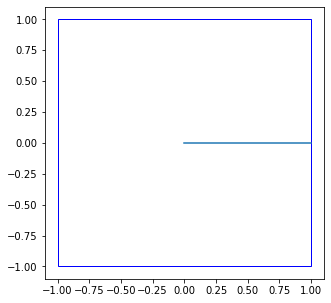

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(5)
ax.plot([0, 1],[0, 0])
ax.add_patch(Rectangle((-1, -1), 2, 2,edgecolor = 'blue',fill = False))
plt.show()

**3.1.2 Laplacian**

Multivariable function is not a must to get the first taste of the Laplacian operator, a second order operator. Indeed, the simplest interpretation lies in the concavity of some simple function. Such as a standard quadratic function:
\begin{equation*}
y = ax^2
\end{equation*}
Please run the next code cell to see the plotting of two such graphs, one with $a>0$ and the other with $a< 0$. Could you tell which is which? Comment some codes and re-run to check your answer!

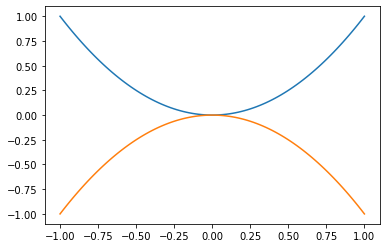

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-1,1,100)
y1 = x**2
y2 = -x**2
plt.plot(x,y1)
plt.plot(x,y2)

For those of you who know some *calculus*, the second order derivative $\frac{d^2y}{dx^2}$ measures the concavity of the function $y(x)$. In our case, the concavity is $2a$, that is the same sign as $a$.

The Laplacian operator, as a second order operator, generalized the measurement of concavity to higher dimensional input, a.k.a. multivariable function, by summing up many second-order partial derivatives (*specifically, by summing up a complete set of second-order derivatives in orthogonal directions without mixing*). Intuitively, could you guess the sign(positive/negative) of the Laplacian of the following function?
\begin{equation*}
u(x,y) = x^2+y^2\\
u(x,y) = -x^2-y^2
\end{equation*}

For some hints, you may run the next code, surface concave upwards should have positive Laplacian; whereas surface concave downwards should have negative Laplacian. For more information, their laplacians are respectively $4$ and $-4$.

P.S. To have more taste on multivariable function, you may refer to **Part A** of [the variants notebook](https://github.com/HanlunAI/ATasteOfDeepLearning/blob/main/ST5_Variants.ipynb) for plotting of some commonly seen surfaces.

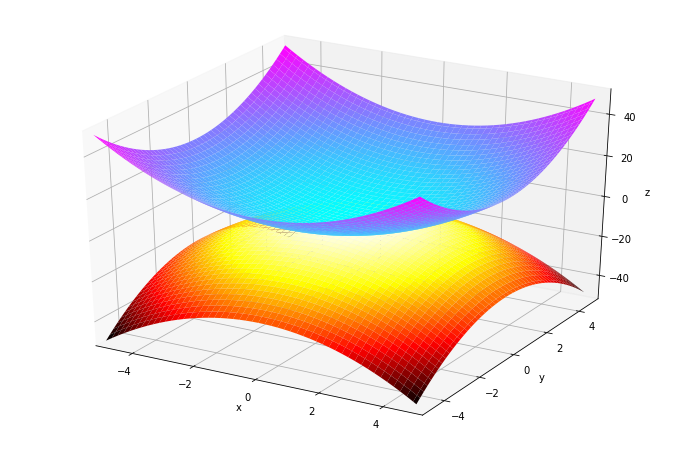

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex

# Make data.
n = 100
X = np.linspace(-5, 5, n, endpoint = False)
Y = np.linspace(-5, 5, n, endpoint = False)
X, Y = np.meshgrid(X, Y)
Z = np.dstack(X**2 + Y**2)
Z = np.append(Z,np.dstack(-X**2 - Y**2), axis = 0)

toDisplay = ["$$z = x^2+y^2$$",
             "$$z = -x^2-y^2$$"]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_figheight(8)
fig.set_figwidth(12)

# Plot the surface.
surf1 = ax.plot_surface(X, Y, Z[0], cmap="cool")
surf2 = ax.plot_surface(X, Y, Z[1], cmap="hot")
# Customize the z axis.

ax.set_xlim3d([-5, 5])
ax.set_ylim3d([-5, 5])
ax.set_zlim(-50,50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

#ax.view_init(70, -70)

plt.show()

display(Latex(toDisplay[0]))
display(Latex(toDisplay[1]))

Boundary value problem is the reverse process, to find the function $u$ with given partial differential equation. In our case:
\begin{equation}
\Delta u = -1
\end{equation}
By linearity of this operator, one could easily get a particular solution like: $u(x,y)=\frac{-x^2-y^2}{4}$ by scaling one of the above plots. Obviously, the solution is not unique unless we introduce more specifications. In addition to the local information from the differential equation in the domain $\Omega$,  we may consider the boundary condition imposed on $\partial \Omega$ to precisely describe some physical systems.


**3.1.3 Approximating a solution with Deep Learning**

In our domain $\Omega$ and and under suitable conditions, the Deep Ritz method takes advantage of a weak formulation of the given Poisson's Equation by $-\Delta u |_{\Omega}=1, u |_{\partial \Omega}=0 \Leftrightarrow \min_{u} {\int_{\Omega} \left(\frac{1}{2}|\nabla u(x,y)|^2-u(x,y) \right) dxdy} + \beta \int_{\partial \Omega} u(x,y)^2 ds$ for $\beta >0$.


The symbol $\nabla u$ is actually the gradient corresponding to a vector pointing at the direction of quickest ascend with a suitable magnitude. For integrals, we can simulate with the Monte Carlo method. The specific boundary condition becomes a penalty added to the integral. Added together, we get the cost function that we wished to minimize.

Recall from previous sessions, deep learning can be applied when one wants to approximate some function (classification, regression, function) by optimizing some other (loss/ measure of error) function. In this case, we want to approximate the solution $u(x,y)$ by minimizing the above weak form, something do-able with deep learning. 

Audience may follow [this github](https://github.com/xdfeng7370/Deep-Ritz-Method) for some Python codes reproduced from Weinan E et al.'s work. A demonstration would also be given in the workshop. After some trials, $\beta =500$ is used as a choice of [*hyperparameter*](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning).

The result is the motivating figure we seen in the first session:

![picture](https://drive.google.com/uc?id=1LjtRtZZp4Cr_FL8sjy3T0osHrf8Liam4)


It may also be viewed in 3D-plot:


![picture](https://drive.google.com/uc?id=1pmjlDgmLjfQ8ABOvjgQMKh2wZcfeQOH4)


### 3.2 News from [Hanlun](https://www.google.com/search?q=Hanlun)

**3.2.1 Real World Measurement**

In endeavor to utilize existing measurement methodology by modern data analytics capability, we also worked on some projects in the direction of upsampling the input and enhancing the output quality. One is on [sound leakage visualization](https://drive.google.com/file/d/1azLgBy0VrMIaEBRJMo6aBUs-0hSMIIij/view?usp=sharing); and one is on [plantar pressure visualization](https://docs.google.com/presentation/d/1yTY00OFeWtj1qGcDZfUld1r58iSiJJjH5GW9-GaFMPs/edit?usp=sharing).

![picture](https://drive.google.com/uc?id=1sIDZTZS6tR66_CBIlScMxEtosd0vdZQT)

The above projects were built with Python, but only little about deep learning is involved. In another project for construction site monitoring, we made more attempts to employ deep learning algorithms [related to audio classification](https://www.youtube.com/watch?v=Lokv8vI8iAQ&t=72s). For that project, we applied for OFCA’s Subsidy Scheme for Encouraging Early Deployment of 5G and [a report is available from here](https://drive.google.com/file/d/1BK4M3ngQjjKAT5XoC9b7_7x8uf0zPg6P/view?usp=sharing).




**3.2.2 Hold On: Recreational Application with Computer Vision**

At another time, we combined body-parts segmentation technique from deep learning and [moving objects detection technique](https://www.researchgate.net/publication/2557021_An_Improved_Adaptive_Background_Mixture_Model_for_Realtime_Tracking_with_Shadow_Detection) from Gaussian Mixtures for a Tai Chi motion sensing application. Later, we repurpose that moving object detection part into a camera with artistic effect upon holding on your phone. 

![picture](https://drive.google.com/uc?id=1T4ySaPziUjXusDOzZwIzvoP1NHPkzpuM)

Please feel free to download and play with the [Android version](https://play.google.com/store/apps/details?id=com.hanlun.holdon) with this QR code:

![picture](https://drive.google.com/uc?id=1oV_ewstalfjyNXde3J-gLnZrtnADiyv2)


Later, you may also submit your moments with this [Gallery](https://drive.google.com/drive/folders/19Ve_dgY1bVrdxGn8eXZFTBZPclc1PyT-).

### 3.3 The World Around Us

**3.3.1 Video time again**

For many decades, traditional numerical methods such as [finite element method](https://en.wikipedia.org/wiki/Finite_element_method) had dominated computational simulation of physical systems. But now deep learning is getting into play with orders of magnitude higher efficiency and just a little bit of loss in accuracy. Please enjoy a simulation on youtube in the next code cell:

In [ ]:
from IPython.display import HTML
HTML('<iframe width="960" height="540" src="https://www.youtube.com/embed/2Bw5f4vYL98" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')


**3.3.2 What's more**

More generally, [here is a survey](https://arxiv.org/abs/1905.11075) of the employment of general machine learning techniques in computational fluid mechanics.

Notably, the video we've seen is part of [DeepMind](https://www.deepmind.com/)'s research (Yes, they have done a lot of work alongside with the success of AlphaGo). In the frontiers, industry is playing an important role and there are more companies to watch out: [Andrew Ng](https://en.wikipedia.org/wiki/Andrew_Ng)'s [Landing AI](https://landing.ai/),  [Jürgen Schmidhuber](https://www.youtube.com/watch?v=-Y7PLaxXUrs&t=553s)'s [nnaisense](https://nnaisense.com/), GPU company [Nvidia](https://www.nvidia.com/en-us/research/), and many other big tech companies (for example Microsoft had the [seeing AI](https://www.microsoft.com/en-us/ai/seeing-ai) for the visually impaired), the list goes on... 

Though we have been concerned with pricing data analytics, computer vision and physical system simulation in previous sessions; AI has much broader application. An important aspect is Natural Language Processing (NLP) and some open resources are offered by [Open AI](https://openai.com/)'s [GPT3](https://gpt3demo.com/). In our city, [LSCM](https://www.lscm.hk/eng/) also has some good [NLP project](https://drive.google.com/file/d/1_eQhImK-y46UjStakHD-yApU82a0WQLX/view?usp=sharing)s. 

Several local universities are offering both Bachelor and [Master](https://hkumath.hku.hk/web/mscai/mindex.php) programs in this area. For oversea programs, here is [a list of popular choices](https://pub.towardsai.net/best-universities-for-artificial-intelligence-ai-programs-3c22cd3e9179).


### 3.4 To record some of our moments

Popularization of related subjects through organizing workshops is surely a frontier!

![picture](https://drive.google.com/uc?id=1IcBWFUCn6JE9FdxLmLKuGintzSpmngT9)

(Created with [Mentimeter](https://www.mentimeter.com/))

### 3.5 What's Past is Prologue

**3.5.1 Humanity**

Other than the acronym of STEM, we note that Prof. Siu Man Keung recently suggested an acronym to include humanity for THAMES appearing in "[The role of M (mathematical worlds) in HPM (history and pedagogy of Mathematics) and in STEM (science, technology, engineering, mathematics)](https://link.springer.com/article/10.1007/s11858-022-01375-1)". In the past few sessions, after having seen how computer technology could be used to do some mathematics to tackle some science and engineering tasks, we should bear in mind that all these are done for the prospect of humanity.

**3.5.2 Keep in touch**

For discussion derived from our workshops, you may write to yktai@hanlunai.com

**3.5.3 [To Be Continued...](https://www.youtube.com/watch?v=hfNa-K3D8kQ)**



